The purpose of this notebook is to answer all of the concerns that Reviewer 4 had

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(taigr) #useful for loading depmap data
library(janitor)
library(ggrepel)

#Output directory for this workspace
#/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: RCurl


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Loading required package: httr


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




# Comment 1

In [2]:
#Load in the CRISPR screening data
achilles.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(achilles.22q1) = word(colnames(achilles.22q1), 1)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-gene-effect.rds



In [3]:
head(achilles.22q1)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,0.11744612,-0.001051181,-0.23395392,-0.03896151,0.13364660,-0.15303238,0.129735459,-0.3250315,0.15751095,⋯,-0.06593203,-0.20919537,0.05741568,-0.01479287,0.091239438,0.12910350,-0.24942409,0.191440845,0.12955310,-0.01438684
2,ACH-000005,-0.01117267,0.073583116,-0.02689838,0.09578112,0.11036335,-0.23910904,0.106212516,-0.3578650,-0.07533758,⋯,-0.02483866,-0.27469658,-0.26798018,-0.12282855,0.002518124,-0.15332301,-0.21807599,0.112961944,-0.01650208,-0.02763737
3,ACH-000007,-0.02289075,-0.005557062,-0.03721019,0.03494349,0.02044321,0.08615090,-0.028631561,-0.3303598,-0.07459645,⋯,-0.12737096,-0.21022478,0.01824790,0.16505336,0.154865739,-0.05926157,-0.20014439,-0.138382457,-0.29673791,-0.28021976
4,ACH-000009,0.06084219,-0.005400561,0.01670920,-0.02544969,0.17202923,-0.06304451,0.005985091,-0.3998144,0.09645066,⋯,-0.11967886,-0.07581406,-0.07777840,0.12409788,0.046490586,0.02356493,-0.46977116,0.109421658,-0.04402405,-0.31711055
5,ACH-000011,0.15160634,0.099379288,0.01929531,0.21254180,0.04312538,-0.20542792,0.046436700,-0.2339292,0.11148982,⋯,-0.48330947,-0.33276154,0.02286435,0.12202867,0.247958115,0.22383858,-0.09603587,-0.002169704,-0.12744714,-0.04949121
6,ACH-000012,-0.04196759,0.093503453,0.12921563,0.20169508,0.17355898,-0.18785047,0.198468321,-0.2553267,0.05206082,⋯,-0.41741509,-0.95221544,-0.01593963,-0.04373990,0.100437487,0.13170388,-0.06641048,0.006659502,-0.05874217,-0.16449399


In [4]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [5]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(achilles.22q1$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(achilles.22q1), colnames(formatted.gene.block.matrix))

final.achilles.22q1 = achilles.22q1 %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

head(final.achilles.22q1)
head(final.gene.block)

dim(final.achilles.22q1)
dim(final.gene.block)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,0.11744612,-0.001051181,-0.23395392,-0.03896151,0.13364660,-0.15303238,0.129735459,-0.3250315,0.15751095,⋯,-0.16551089,-0.02562803,-0.065932029,-0.20919537,0.091239438,0.1291035015,-0.24942409,0.191440845,0.12955310,-0.01438684
2,ACH-000005,-0.01117267,0.073583116,-0.02689838,0.09578112,0.11036335,-0.23910904,0.106212516,-0.3578650,-0.07533758,⋯,-0.34383867,-0.31638189,-0.024838665,-0.27469658,0.002518124,-0.1533230138,-0.21807599,0.112961944,-0.01650208,-0.02763737
3,ACH-000007,-0.02289075,-0.005557062,-0.03721019,0.03494349,0.02044321,0.08615090,-0.028631561,-0.3303598,-0.07459645,⋯,-0.12671539,-0.37945164,-0.127370960,-0.21022478,0.154865739,-0.0592615664,-0.20014439,-0.138382457,-0.29673791,-0.28021976
4,ACH-000009,0.06084219,-0.005400561,0.01670920,-0.02544969,0.17202923,-0.06304451,0.005985091,-0.3998144,0.09645066,⋯,0.04038080,-0.24526231,-0.119678863,-0.07581406,0.046490586,0.0235649287,-0.46977116,0.109421658,-0.04402405,-0.31711055
5,ACH-000012,-0.04196759,0.093503453,0.12921563,0.20169508,0.17355898,-0.18785047,0.198468321,-0.2553267,0.05206082,⋯,0.02775213,-0.37480690,-0.417415089,-0.95221544,0.100437487,0.1317038833,-0.06641048,0.006659502,-0.05874217,-0.16449399
6,ACH-000013,0.00998090,-0.021292932,-0.04064724,0.08794246,0.01174277,-0.09741850,0.020148161,-0.3076077,-0.04163766,⋯,-0.05298880,-1.12238846,-0.004032217,0.13630928,0.163914087,0.0009830282,-0.07391150,0.062107667,-0.16896519,-0.32896727


,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000004,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
2,ACH-000005,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
3,ACH-000007,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
4,ACH-000009,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000012,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000013,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


[1]   558 16952

[1]   558 16952

In [8]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [9]:
#Calculate p-values and mean differences for 22q1

gene.names = colnames(final.achilles.22q1)[2:ncol(final.achilles.22q1)]


afr.pval.vector = NULL
amr.pval.vector = NULL
eas.pval.vector = NULL
eur.pval.vector = NULL
sas.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.achilles.22q1 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.pval.vector = c(afr.pval.vector, afr.pval)
    amr.pval.vector = c(amr.pval.vector, amr.pval)
    eas.pval.vector = c(eas.pval.vector, eas.pval)
    eur.pval.vector = c(eur.pval.vector, eur.pval)
    sas.pval.vector = c(sas.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [10]:
#First, create datasets for each ancestry group, then cat them.
afr.volcano.df = cbind(gene.names, afr.pval.vector, afr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df = cbind(gene.names, amr.pval.vector, amr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df = cbind(gene.names, eas.pval.vector, eas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df = cbind(gene.names, eur.pval.vector, eur.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df = cbind(gene.names, sas.pval.vector, sas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df = rbind(afr.volcano.df, amr.volcano.df, eas.volcano.df, eur.volcano.df, sas.volcano.df) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

head(cat.volcano.df)
tail(cat.volcano.df)

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.5023609,0.0183208574,AFR,1
2,A1CF,0.9830007,0.0005046055,AFR,1
3,A2M,0.8686871,-0.0006612870,AFR,1
4,A2ML1,0.2586242,0.0208188943,AFR,1
5,A3GALT2,0.6097706,-0.0104624547,AFR,1
6,A4GALT,0.9369998,0.0044760289,AFR,1


,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
84750,ZXDC,1.0000000,-0.05777144,SAS,1
84751,ZYG11A,1.0000000,-0.04823526,SAS,1
84752,ZYG11B,1.0000000,0.05114193,SAS,1
84753,ZYX,0.4372270,-0.06731900,SAS,1
84754,ZZEF1,0.8140801,0.04295974,SAS,1
84755,ZZZ3,1.0000000,-0.09172472,SAS,1


In [11]:
#Write the dataset so that we don't need to re-read it
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
write.table(cat.volcano.df, "achilles_only_ancestry_pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Now calculate the differences between the combined and the achilles-only

In [16]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

#Format the old lineage corrected p-values in a goofy way because of how I coded things before.
gene.vector = c(lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene)
pval.vector = c(lineage.corrected.pvals$afr.lm.pval.vector, lineage.corrected.pvals$amr.lm.pval.vector, lineage.corrected.pvals$eas.lm.pval.vector, lineage.corrected.pvals$eur.lm.pval.vector, lineage.corrected.pvals$sas.lm.pval.vector)
diff.vector = c(lineage.corrected.pvals$afr.mean.dif, lineage.corrected.pvals$amr.mean.dif, lineage.corrected.pvals$eas.mean.dif, lineage.corrected.pvals$eur.mean.dif, lineage.corrected.pvals$sas.mean.dif)
fdr.vector = c(lineage.corrected.pvals$afr_fdr, lineage.corrected.pvals$amr_fdr, lineage.corrected.pvals$eas_fdr, lineage.corrected.pvals$eur_fdr, lineage.corrected.pvals$sas_fdr)
ancestry.vector = c(rep("AFR", times = length(gene.vector)/5), rep("AMR", times = length(gene.vector)/5), rep("EAS", times = length(gene.vector)/5), rep("EUR", times = length(gene.vector)/5), rep("SAS", times = length(gene.vector)/5))
gene.ancestry.vector = paste(gene.vector, "_", ancestry.vector, sep = "")

#Bind all of the vectors together
combined.volcano.df = cbind(gene.vector, pval.vector, diff.vector, ancestry.vector, fdr.vector, gene.ancestry.vector) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3, "ancestry" = 4, "FDR" = 5, "gene_ancestry" = 6) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = as.numeric(FDR))

head(combined.volcano.df)


,gene,pval,difference,ancestry,FDR,gene_ancestry
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,A1BG,0.51570812,0.018967685,AFR,0.998556,A1BG_AFR
2,A1CF,0.09749307,-0.035117475,AFR,0.998556,A1CF_AFR
3,A2M,0.68035925,-0.010031350,AFR,0.998556,A2M_AFR
4,A2ML1,0.61602149,0.009988105,AFR,0.998556,A2ML1_AFR
5,A3GALT2,0.76637396,0.003320528,AFR,0.998556,A3GALT2_AFR
6,A4GALT,0.87370145,0.004528391,AFR,0.998556,A4GALT_AFR


In [17]:
#Create a merged dataset
merged.pval.matrix = cat.volcano.df %>%
rename("achilles_gene" = 1, "achilles_pval" = 2, "achilles_difference" = 3, "achilles_ancestry" = 4, "achilles_fdr" = 5) %>%
mutate(gene_ancestry = paste(achilles_gene, achilles_ancestry, sep = "_")) %>%
inner_join(combined.volcano.df, by = "gene_ancestry") %>%
rename("merged_gene" = 7, "merged_pval" = 8, "merged_difference" = 9, "merged_ancestry" = 10, "merged_fdr" = 11)



head(merged.pval.matrix)

,achilles_gene,achilles_pval,achilles_difference,achilles_ancestry,achilles_fdr,gene_ancestry,merged_gene,merged_pval,merged_difference,merged_ancestry,merged_fdr
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.5023609,0.0183208574,AFR,1,A1BG_AFR,A1BG,0.51570812,0.018967685,AFR,0.998556
2,A1CF,0.9830007,0.0005046055,AFR,1,A1CF_AFR,A1CF,0.09749307,-0.035117475,AFR,0.998556
3,A2M,0.8686871,-0.0006612870,AFR,1,A2M_AFR,A2M,0.68035925,-0.010031350,AFR,0.998556
4,A2ML1,0.2586242,0.0208188943,AFR,1,A2ML1_AFR,A2ML1,0.61602149,0.009988105,AFR,0.998556
5,A3GALT2,0.6097706,-0.0104624547,AFR,1,A3GALT2_AFR,A3GALT2,0.76637396,0.003320528,AFR,0.998556
6,A4GALT,0.9369998,0.0044760289,AFR,1,A4GALT_AFR,A4GALT,0.87370145,0.004528391,AFR,0.998556


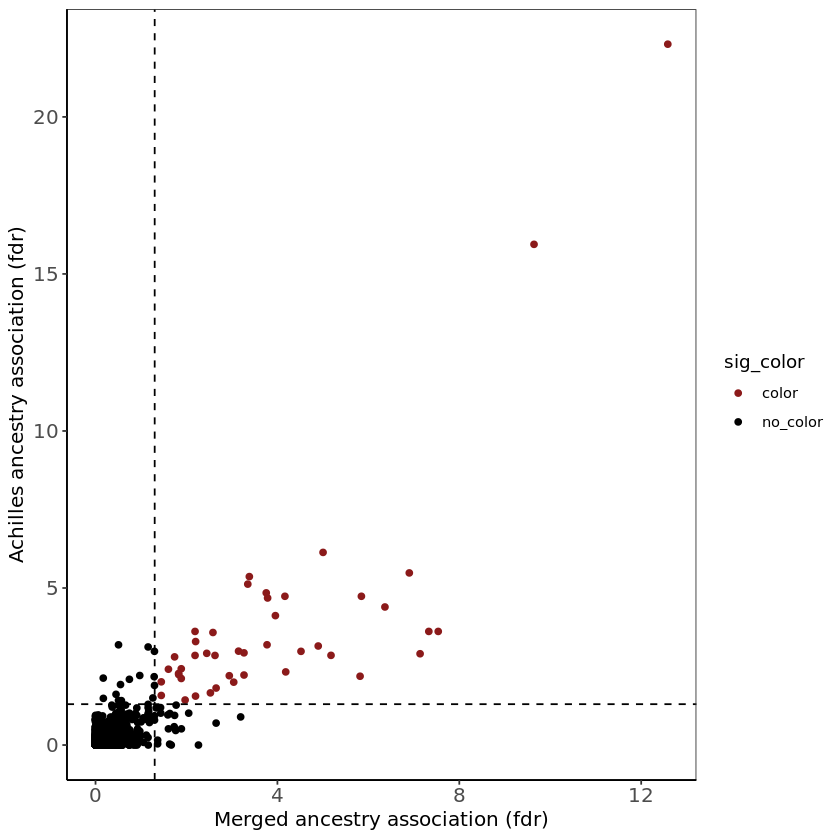

In [19]:
#Correlate the p-values from the achilles only and the merged
merged.pval.matrix %>%
mutate("sig_color" = ifelse(achilles_fdr < 0.05 & merged_fdr < 0.05, "color", "no_color")) %>%
ggplot(aes(x = -log10(merged_fdr), y = -log10(achilles_fdr), color = sig_color)) +
geom_point() +

geom_hline(yintercept = 1.301, linetype = 2) +
geom_vline(xintercept = 1.301, linetype = 2) +

scale_color_manual(values = c("firebrick4", "black")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +


ylab("Achilles ancestry association (fdr)") +
xlab("Merged ancestry association (fdr)")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
ggsave("r4c1_achilles_merged_correlation_plot.pdf", width = 5, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4
gsutil cp r4c1_achilles_merged_correlation_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [20]:
#Calculate the total number of significant genes in each dataset
merged.pval.matrix %>% filter(achilles_fdr < 0.05) %>% pull(achilles_gene) %>% unique() %>% length()
merged.pval.matrix %>% filter(merged_fdr < 0.05) %>% pull(merged_gene) %>% unique() %>% length()
merged.pval.matrix %>% filter(achilles_fdr < 0.05 & merged_fdr < 0.05) %>% pull(achilles_gene) %>% unique() %>% length()

[1] 46

[1] 49

[1] 34

# Comment 1 (lineage correction)

In [8]:
#Load in the chronos scores
chronos.scores.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
rename_all(~sub(" .*", "", .))

chronos.scores.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
rename_all(~sub(" .*", "", .))

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/14 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_14.toc 


Loading from cached file /home/jupyter/.taiga/72c31542d4034fd8aa4f0b25e91e8ce6_crispr-gene-effect.rds



In [43]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [46]:
#Get two vectors of intersecting samples and genes
intersecting.samples = intersect(chronos.scores.22q1$sample, chronos.scores.22q2$sample) %>% intersect(., formatted.gene.block.matrix$sample)
intersecting.columns = intersect(colnames(chronos.scores.22q1), colnames(chronos.scores.22q2)) %>% intersect(., colnames(formatted.gene.block.matrix))

#Now filter the two datasets so that they only included the intersecting samples and genes
final.chronos.22q1 = chronos.scores.22q1 %>% 
filter(sample %in% all_of(intersecting.samples)) %>%
select(all_of(intersecting.columns))

final.chronos.22q2 = chronos.scores.22q2 %>%
filter(sample %in% all_of(intersecting.samples)) %>%
select(all_of(intersecting.columns))

#Filter gene block matrix so it only includes the genes and samples we are interested in
final.gene.block.matrix = formatted.gene.block.matrix %>%
filter(sample %in% all_of(intersecting.samples)) %>%
select(all_of(intersecting.columns))

final.chronos.22q1 %>% dim()
final.chronos.22q2 %>% dim()
final.gene.block.matrix %>% dim()

[1]   611 16385

[1]   611 16385

[1]   611 16385

In [15]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [50]:
#Calculate p-values and mean differences for 22q1

gene.names = colnames(final.chronos.22q1)[2:ncol(final.chronos.22q1)]


afr.lm.pval.vector.22q1 = NULL
amr.lm.pval.vector.22q1 = NULL
eas.lm.pval.vector.22q1 = NULL
eur.lm.pval.vector.22q1 = NULL
sas.lm.pval.vector.22q1 = NULL
afr.mean.dif.22q1 = NULL
amr.mean.dif.22q1 = NULL
eas.mean.dif.22q1 = NULL
eur.mean.dif.22q1 = NULL
sas.mean.dif.22q1 = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.chronos.22q1 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block.matrix %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.lm.pval.vector.22q1 = c(afr.lm.pval.vector.22q1, afr.pval)
    amr.lm.pval.vector.22q1 = c(amr.lm.pval.vector.22q1, amr.pval)
    eas.lm.pval.vector.22q1 = c(eas.lm.pval.vector.22q1, eas.pval)
    eur.lm.pval.vector.22q1 = c(eur.lm.pval.vector.22q1, eur.pval)
    sas.lm.pval.vector.22q1 = c(sas.lm.pval.vector.22q1, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif.22q1 = c(afr.mean.dif.22q1, afr.dif)
    amr.mean.dif.22q1 = c(amr.mean.dif.22q1, amr.dif)
    eas.mean.dif.22q1 = c(eas.mean.dif.22q1, eas.dif)
    eur.mean.dif.22q1 = c(eur.mean.dif.22q1, eur.dif)
    sas.mean.dif.22q1 = c(sas.mean.dif.22q1, sas.dif)
}

In [51]:
#Calculate p-values and mean differences for 22q2

gene.names = colnames(final.chronos.22q2)[2:ncol(final.chronos.22q2)]


afr.lm.pval.vector.22q2 = NULL
amr.lm.pval.vector.22q2 = NULL
eas.lm.pval.vector.22q2 = NULL
eur.lm.pval.vector.22q2 = NULL
sas.lm.pval.vector.22q2 = NULL
afr.mean.dif.22q2 = NULL
amr.mean.dif.22q2 = NULL
eas.mean.dif.22q2 = NULL
eur.mean.dif.22q2 = NULL
sas.mean.dif.22q2 = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.chronos.22q2 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block.matrix %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.lm.pval.vector.22q2 = c(afr.lm.pval.vector.22q2, afr.pval)
    amr.lm.pval.vector.22q2 = c(amr.lm.pval.vector.22q2, amr.pval)
    eas.lm.pval.vector.22q2 = c(eas.lm.pval.vector.22q2, eas.pval)
    eur.lm.pval.vector.22q2 = c(eur.lm.pval.vector.22q2, eur.pval)
    sas.lm.pval.vector.22q2 = c(sas.lm.pval.vector.22q2, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif.22q2 = c(afr.mean.dif.22q2, afr.dif)
    amr.mean.dif.22q2 = c(amr.mean.dif.22q2, amr.dif)
    eas.mean.dif.22q2 = c(eas.mean.dif.22q2, eas.dif)
    eur.mean.dif.22q2 = c(eur.mean.dif.22q2, eur.dif)
    sas.mean.dif.22q2 = c(sas.mean.dif.22q2, sas.dif)
}

In [52]:
###Export the two datasets so that we don't need to do that again

#Construct the dataset for 22q1
#Construct a dataset with all of this information
pval.df.22q1 = cbind(afr.lm.pval.vector.22q1, amr.lm.pval.vector.22q1, eas.lm.pval.vector.22q1, eur.lm.pval.vector.22q1, sas.lm.pval.vector.22q1, afr.mean.dif.22q1, amr.mean.dif.22q1, eas.mean.dif.22q1, eur.mean.dif.22q1, sas.mean.dif.22q1) %>%
data.frame() %>%
mutate("gene" = gene.names, .before = 1) %>%
mutate("afr_fdr" = p.adjust(afr.lm.pval.vector.22q1, method = "BH", n = length(afr.lm.pval.vector.22q1))) %>%
mutate("amr_fdr" = p.adjust(amr.lm.pval.vector.22q1, method = "BH", n = length(amr.lm.pval.vector.22q1))) %>%
mutate("eas_fdr" = p.adjust(eas.lm.pval.vector.22q1, method = "BH", n = length(eas.lm.pval.vector.22q1))) %>%
mutate("eur_fdr" = p.adjust(eur.lm.pval.vector.22q1, method = "BH", n = length(eur.lm.pval.vector.22q1))) %>%
mutate("sas_fdr" = p.adjust(sas.lm.pval.vector.22q1, method = "BH", n = length(sas.lm.pval.vector.22q1))) %>%
rename("afr_pval" = 2, "amr_pval" = 3, "eas_pval" = 4, "eur_pval" = 5, "sas_pval" = 6) %>%
rename("afr_mean_diff" = 7, "amr_mean_diff" = 8, "eas_mean_diff" = 9, "eur_mean_diff" = 10, "sas_mean_diff" = 11)

pval.df.22q2 = cbind(afr.lm.pval.vector.22q2, amr.lm.pval.vector.22q2, eas.lm.pval.vector.22q2, eur.lm.pval.vector.22q2, sas.lm.pval.vector.22q2, afr.mean.dif.22q2, amr.mean.dif.22q2, eas.mean.dif.22q2, eur.mean.dif.22q2, sas.mean.dif.22q2) %>%
data.frame() %>%
mutate("gene" = gene.names, .before = 1) %>%
mutate("afr_fdr" = p.adjust(afr.lm.pval.vector.22q2, method = "BH", n = length(afr.lm.pval.vector.22q2))) %>%
mutate("amr_fdr" = p.adjust(amr.lm.pval.vector.22q2, method = "BH", n = length(amr.lm.pval.vector.22q2))) %>%
mutate("eas_fdr" = p.adjust(eas.lm.pval.vector.22q2, method = "BH", n = length(eas.lm.pval.vector.22q2))) %>%
mutate("eur_fdr" = p.adjust(eur.lm.pval.vector.22q2, method = "BH", n = length(eur.lm.pval.vector.22q2))) %>%
mutate("sas_fdr" = p.adjust(sas.lm.pval.vector.22q2, method = "BH", n = length(sas.lm.pval.vector.22q2))) %>%
rename("afr_pval" = 2, "amr_pval" = 3, "eas_pval" = 4, "eur_pval" = 5, "sas_pval" = 6) %>%
rename("afr_mean_diff" = 7, "amr_mean_diff" = 8, "eas_mean_diff" = 9, "eur_mean_diff" = 10, "sas_mean_diff" = 11)

#Write the two datasets
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
write.table(pval.df.22q1, "ancestry_associated_pval_lineage_correction_22q1.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
write.table(pval.df.22q2, "ancestry_associated_pval_lineage_correction_22q2.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [70]:
#Calculate the number of significant associations
pval.df.22q1 %>% 
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05)

gene,afr_pval,amr_pval,eas_pval,eur_pval,sas_pval,afr_mean_diff,amr_mean_diff,eas_mean_diff,eur_mean_diff,sas_mean_diff,afr_fdr,amr_fdr,eas_fdr,eur_fdr,sas_fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABHD5,5.029064e-01,6.731293e-01,1.419840e-04,7.325947e-05,1.00000000,-0.013409333,0.0219651014,-0.032870455,0.031810393,0.040454712,9.998078e-01,1.0000000000,5.673820e-02,3.530245e-02,1
ATOH1,2.515906e-01,6.035723e-08,7.642248e-01,1.120672e-01,1.00000000,-0.018784078,-0.2460395453,-0.005028698,0.016397610,0.001926937,9.998078e-01,0.0004944464,9.640037e-01,7.422146e-01,1
ATP6V0E1,1.892691e-03,2.650515e-02,3.773307e-02,1.839334e-05,1.00000000,-0.147688999,-0.1811022707,-0.046207095,0.079448564,-0.076158852,4.784503e-01,1.0000000000,5.301130e-01,1.310246e-02,1
BRAF,1.443207e-01,1.000000e+00,5.214319e-05,4.503751e-03,1.00000000,0.065334238,-0.8376455999,0.071713743,-0.074058027,0.070252934,9.998078e-01,1.0000000000,2.945517e-02,3.194349e-01,1
C2orf80,7.979514e-01,6.053948e-01,2.033376e-05,1.526936e-05,0.63512189,-0.009448367,0.0356221501,-0.045197475,0.042714631,0.033353581,9.998078e-01,1.0000000000,1.332593e-02,1.191301e-02,1
CCDC74B,5.621591e-01,2.759222e-01,6.901363e-07,3.539659e-09,1.00000000,-0.024543386,0.0804197765,-0.079704723,0.077621608,-0.007011342,9.998078e-01,1.0000000000,1.256355e-03,1.449844e-05,1
CDKN2B,2.279463e-05,7.832736e-01,9.731180e-01,4.880268e-04,1.00000000,0.064926397,-0.0078898650,-0.004968188,-0.032872679,-0.100050763,1.957885e-02,1.0000000000,9.977479e-01,1.161740e-01,1
CHGB,1.905154e-01,5.768611e-01,6.505422e-05,9.395311e-05,1.00000000,-0.026503202,-0.0274902299,0.042385715,-0.033555982,-0.066873581,9.998078e-01,1.0000000000,3.232727e-02,4.050863e-02,1
CLSPN,6.011614e-02,7.391213e-01,8.991061e-19,6.889402e-23,1.00000000,0.105076936,-0.0744837949,0.221512039,-0.227785494,0.192494991,9.998078e-01,1.0000000000,1.473095e-14,1.128760e-18,1


In [53]:
#Read the files back in (if necessary)
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
pval.df.22q1 = read.table("ancestry_associated_pval_lineage_correction_22q1.txt", sep = "\t", header = T)
pval.df.22q2 = read.table("ancestry_associated_pval_lineage_correction_22q2.txt", sep = "\t", header = T)

In [54]:
#Make the correlation plot for Figure 4
#Make this plot with only the minimal fdr for each gene

#Calculate the min fdr for 22q1
minimum.fdr.22q1 = pval.df.22q1 %>%
rowwise() %>%
mutate("min_fdr" = min(c_across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr) %>%
rename("min_fdr_22q1" = min_fdr)

#Calculate the min fdr for 22q2
minimum.fdr.22q2 = pval.df.22q2 %>%
rowwise() %>%
mutate("min_fdr" = min(c_across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr) %>%
rename("min_fdr_22q2" = min_fdr)

#Bind the two datasets together
min.fdr.both.datasets = inner_join(minimum.fdr.22q1, minimum.fdr.22q2, by = "gene")

min.fdr.both.datasets %>% head()

gene,min_fdr_22q1,min_fdr_22q2
<chr>,<dbl>,<dbl>
A1BG,0.7840050,0.8212421
A1CF,0.3012055,0.3290478
A2M,0.7508653,0.7381969
A2ML1,0.7045613,0.6767793
A3GALT2,0.6228982,0.6651930
A4GALT,0.8145870,0.8059326


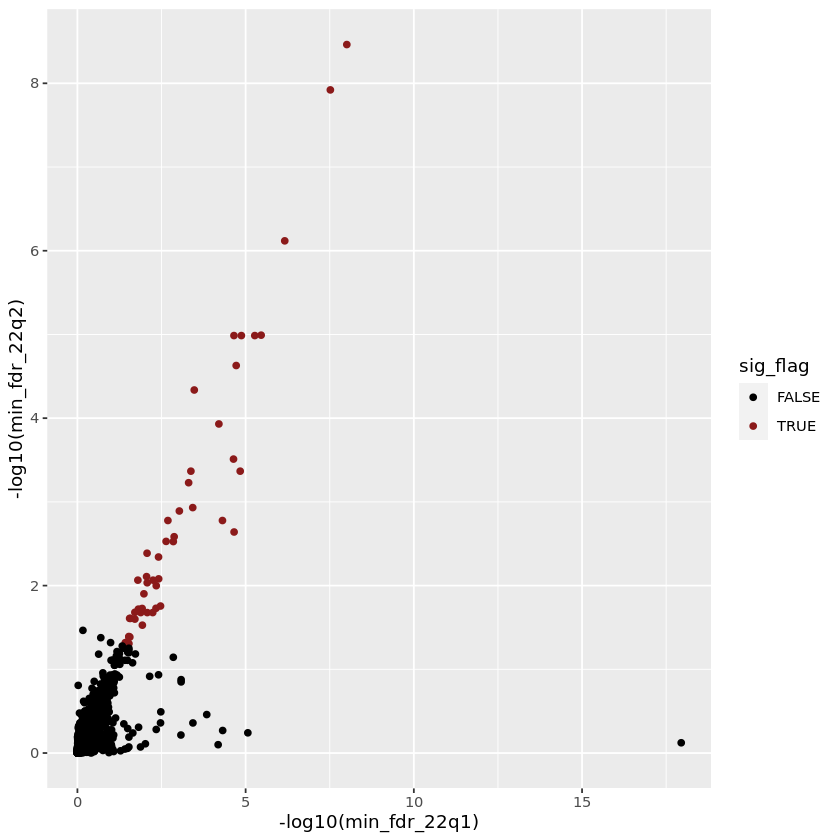

In [56]:
#Make the scatterplot
min.fdr.both.datasets %>%
mutate("sig_flag" = ifelse(min_fdr_22q1 < 0.05 & min_fdr_22q2 < 0.05, TRUE, FALSE)) %>%
ggplot(aes(x = -log10(min_fdr_22q1), y = -log10(min_fdr_22q2), color = sig_flag)) +
geom_point() +

scale_color_manual(values = c("black", "firebrick4")) +

geom_hline(yintercept = 1.301, linetype = 2) +
geom_vline(xintercept = 1.301, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +


ylab("Post-correction ancestry association (FDR)") +
xlab("Pre-correction ancestry association (FDR)")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
ggsave("r4c1_pre_post_lineage_correction.pdf", width = 5, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4
gsutil cp r4c1_pre_post_lineage_correction.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))




In [64]:
#Count some stuff
min.fdr.both.datasets %>%
filter(min_fdr_22q1 < 0.05) %>%
pull(gene) %>%
unique() %>%
length()



[1] 84

In [65]:
min.fdr.both.datasets %>% head()

gene,min_fdr_22q1,min_fdr_22q2
<chr>,<dbl>,<dbl>
A1BG,0.7840050,0.8212421
A1CF,0.3012055,0.3290478
A2M,0.7508653,0.7381969
A2ML1,0.7045613,0.6767793
A3GALT2,0.6228982,0.6651930
A4GALT,0.8145870,0.8059326


# Comment 2

In [92]:
#Load in the CRISPR screening data

#for 22q1
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q1) = word(colnames(chronos.22q1), 1)

#and 22q2
chronos.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q2) = word(colnames(chronos.22q2), 1)


Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



In [93]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [94]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(chronos.22q1$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(chronos.22q1), colnames(formatted.gene.block.matrix))

#For 22q1
final.chronos.22q1 = chronos.22q1 %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

#and 22q2
final.chronos.22q2 = chronos.22q2 %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.016751717,-0.4675348,-0.05643839,-0.1176586,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.141819984,0.1195287,-0.10724648,-0.2477974,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.304217262,-0.1466795,-0.05148461,-0.3344562,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.195726053,-0.2546972,-0.27257956,-0.4733824,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,0.028096552,-0.1723441,-0.18239415,-0.3284529,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000012,-0.10647815,0.01288647,0.16741875,0.227102498,0.07689544,-0.21553977,0.18137996,-0.1281190,0.004292332,⋯,-0.001588165,-0.1282899,-0.53368428,-1.1187548,0.06429254,0.05243090,-0.04087758,-0.075470757,-0.03858331,-0.24810776


,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000001,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
2,ACH-000004,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
3,ACH-000005,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
4,ACH-000007,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000009,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000012,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


[1]   611 16385

[1]   611 16385

In [95]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [96]:
#Calculate p-values and mean differences for 22q1

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]


afr.lm.pval.vector = NULL
amr.lm.pval.vector = NULL
eas.lm.pval.vector = NULL
eur.lm.pval.vector = NULL
sas.lm.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.chronos.22q1 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.lm.pval.vector = c(afr.lm.pval.vector, afr.pval)
    amr.lm.pval.vector = c(amr.lm.pval.vector, amr.pval)
    eas.lm.pval.vector = c(eas.lm.pval.vector, eas.pval)
    eur.lm.pval.vector = c(eur.lm.pval.vector, eur.pval)
    sas.lm.pval.vector = c(sas.lm.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [97]:
#Construct a dataset with all of this information
lm.pval.df = cbind(afr.lm.pval.vector, amr.lm.pval.vector, eas.lm.pval.vector, eur.lm.pval.vector, sas.lm.pval.vector, afr.mean.dif, amr.mean.dif, eas.mean.dif, eur.mean.dif, sas.mean.dif) %>%
data.frame() %>%
mutate("gene" = gene.names, .before = 1) %>%
mutate("afr_fdr" = p.adjust(afr.lm.pval.vector, method = "BH", n = length(afr.lm.pval.vector))) %>%
mutate("amr_fdr" = p.adjust(amr.lm.pval.vector, method = "BH", n = length(amr.lm.pval.vector))) %>%
mutate("eas_fdr" = p.adjust(eas.lm.pval.vector, method = "BH", n = length(eas.lm.pval.vector))) %>%
mutate("eur_fdr" = p.adjust(eur.lm.pval.vector, method = "BH", n = length(eur.lm.pval.vector))) %>%
mutate("sas_fdr" = p.adjust(sas.lm.pval.vector, method = "BH", n = length(sas.lm.pval.vector)))


head(lm.pval.df)

,gene,afr.lm.pval.vector,amr.lm.pval.vector,eas.lm.pval.vector,eur.lm.pval.vector,sas.lm.pval.vector,afr.mean.dif,amr.mean.dif,eas.mean.dif,eur.mean.dif,sas.mean.dif,afr_fdr,amr_fdr,eas_fdr,eur_fdr,sas_fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.51570812,0.5243904,0.33508618,0.51316820,1.0000000,0.018967685,0.039100054,-0.011154457,0.006603833,-0.226423809,0.998556,1,0.9184664,0.9703296,1
2,A1CF,0.09749307,0.9998859,0.73471568,0.70146509,0.5597664,-0.035117475,0.027514943,-0.002246655,0.007144719,0.030043081,0.998556,1,0.9771815,0.9821999,1
3,A2M,0.68035925,1.0000000,0.51713036,0.53660729,1.0000000,-0.010031350,0.038566520,-0.001514329,0.001920044,0.046502802,0.998556,1,0.9548815,0.9720597,1
4,A2ML1,0.61602149,0.6843036,0.09231594,0.06193838,1.0000000,0.009988105,0.013638286,0.009534186,-0.010934267,0.004499364,0.998556,1,0.7843746,0.8105684,1
5,A3GALT2,0.76637396,1.0000000,0.70909158,0.83017049,0.9866729,0.003320528,0.001137803,-0.016077768,0.014507092,-0.002840530,0.998556,1,0.9753693,0.9917531,1
6,A4GALT,0.87370145,1.0000000,0.13340200,0.13581386,1.0000000,0.004528391,0.019587428,-0.008987721,0.008747816,-0.096587268,0.998556,1,0.8209225,0.8739186,1


In [99]:
#Now do the same thing for 22q2

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]


afr.lm.pval.vector.22q2 = NULL
amr.lm.pval.vector.22q2 = NULL
eas.lm.pval.vector.22q2 = NULL
eur.lm.pval.vector.22q2 = NULL
sas.lm.pval.vector.22q2 = NULL
afr.mean.dif.22q2 = NULL
amr.mean.dif.22q2 = NULL
eas.mean.dif.22q2 = NULL
eur.mean.dif.22q2 = NULL
sas.mean.dif.22q2 = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.chronos.22q2 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.lm.pval.vector.22q2 = c(afr.lm.pval.vector.22q2, afr.pval)
    amr.lm.pval.vector.22q2 = c(amr.lm.pval.vector.22q2, amr.pval)
    eas.lm.pval.vector.22q2 = c(eas.lm.pval.vector.22q2, eas.pval)
    eur.lm.pval.vector.22q2 = c(eur.lm.pval.vector.22q2, eur.pval)
    sas.lm.pval.vector.22q2 = c(sas.lm.pval.vector.22q2, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif.22q2 = c(afr.mean.dif.22q2, afr.dif)
    amr.mean.dif.22q2 = c(amr.mean.dif.22q2, amr.dif)
    eas.mean.dif.22q2 = c(eas.mean.dif.22q2, eas.dif)
    eur.mean.dif.22q2 = c(eur.mean.dif.22q2, eur.dif)
    sas.mean.dif.22q2 = c(sas.mean.dif.22q2, sas.dif)
}

In [100]:
#Construct a dataset with all of this information
lm.pval.df.22q2 = cbind(afr.lm.pval.vector.22q2, amr.lm.pval.vector.22q2, eas.lm.pval.vector.22q2, eur.lm.pval.vector.22q2, sas.lm.pval.vector.22q2, afr.mean.dif.22q2, amr.mean.dif.22q2, eas.mean.dif.22q2, eur.mean.dif.22q2, sas.mean.dif.22q2) %>%
data.frame() %>%
mutate("gene" = gene.names, .before = 1) %>%
mutate("afr_fdr" = p.adjust(afr.lm.pval.vector.22q2, method = "BH", n = length(afr.lm.pval.vector.22q2))) %>%
mutate("amr_fdr" = p.adjust(amr.lm.pval.vector.22q2, method = "BH", n = length(amr.lm.pval.vector.22q2))) %>%
mutate("eas_fdr" = p.adjust(eas.lm.pval.vector.22q2, method = "BH", n = length(eas.lm.pval.vector.22q2))) %>%
mutate("eur_fdr" = p.adjust(eur.lm.pval.vector.22q2, method = "BH", n = length(eur.lm.pval.vector.22q2))) %>%
mutate("sas_fdr" = p.adjust(sas.lm.pval.vector.22q2, method = "BH", n = length(sas.lm.pval.vector.22q2)))


head(lm.pval.df.22q2)

,gene,afr.lm.pval.vector.22q2,amr.lm.pval.vector.22q2,eas.lm.pval.vector.22q2,eur.lm.pval.vector.22q2,sas.lm.pval.vector.22q2,afr.mean.dif.22q2,amr.mean.dif.22q2,eas.mean.dif.22q2,eur.mean.dif.22q2,sas.mean.dif.22q2,afr_fdr,amr_fdr,eas_fdr,eur_fdr,sas_fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.63607402,0.4347907,0.24718420,0.37926825,1.0000000,0.014246271,0.047282961,-0.012410097,0.008117148,-0.223069865,0.9999923,1,0.9052003,0.9586727,1
2,A1CF,0.08152746,0.7294415,0.79898092,0.66298261,0.5208707,-0.038100883,0.044809258,-0.003628359,0.008491365,0.035171822,0.9999923,1,0.9848630,0.9867853,1
3,A2M,0.69694086,1.0000000,0.45680164,0.48365880,1.0000000,-0.009297125,0.035183347,-0.002255537,0.002553366,0.045833413,0.9999923,1,0.9479719,0.9785046,1
4,A2ML1,0.71604993,0.8478363,0.07015254,0.06577663,1.0000000,0.007199391,-0.023627374,0.010597730,-0.010809465,0.010846957,0.9999923,1,0.8029020,0.8624431,1
5,A3GALT2,0.70774004,1.0000000,0.79703538,0.93419916,0.9916234,0.005166178,-0.003243663,-0.015240973,0.013478353,-0.005084751,0.9999923,1,0.9848630,0.9959178,1
6,A4GALT,0.82364593,1.0000000,0.12362926,0.12837428,1.0000000,0.005254821,0.005388613,-0.009904195,0.009703529,-0.098166525,0.9999923,1,0.8367271,0.9023872,1


In [102]:
lm.pval.df.22q2 %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique() %>%
length()



lm.pval.df %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique() %>%
length()

[1] 38

[1] 49

In [105]:
#Write two datasets so that we don't need to re-compute everything
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
write.table(lm.pval.df, "chronos_22q1_ancestry_associated_dependency_pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
write.table(lm.pval.df.22q2, "chronos_22q2_ancestry_associated_dependency_pvals.txt", sep  = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [106]:
#Read the datasets back in, if necessary
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lm.pval.df = read.table("chronos_22q1_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)
lm.pval.df.22q2 = read.table("chronos_22q2_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

In [6]:
#Make a data frame that we can use for creating the volcano plot
differential.df = lm.pval.df %>%
select(gene, afr.mean.dif, amr.mean.dif, eas.mean.dif, eur.mean.dif, sas.mean.dif) %>%
melt(id = "gene") %>%
rename("ancestry" = 2, "differential" = 3) %>%
mutate(ancestry = gsub("\\..*", "", ancestry)) %>%
mutate("flag" = paste(gene, ancestry, sep = "_"))

fdr.df = lm.pval.df %>%
select(gene, "afr_fdr", "amr_fdr", "eas_fdr", "eur_fdr", "sas_fdr") %>%
melt(id = "gene") %>%
rename("ancestry" = 2, "fdr" = 3) %>%
mutate(ancestry = gsub("_..*", "", ancestry)) %>%
mutate("flag" = paste(gene, ancestry, sep = "_"))


#Merge the fdr and the differential data together
merged.df.for.volcano.plot = inner_join(differential.df, fdr.df, by = "flag") %>%
select(-ancestry.x, -gene.y) %>%
rename("gene" = 1, "ancestry" = 4)

head(merged.df.for.volcano.plot)

,gene,differential,flag,ancestry,fdr
,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,A1BG,0.018967685,A1BG_afr,afr,0.998556
2,A1CF,-0.035117475,A1CF_afr,afr,0.998556
3,A2M,-0.010031350,A2M_afr,afr,0.998556
4,A2ML1,0.009988105,A2ML1_afr,afr,0.998556
5,A3GALT2,0.003320528,A3GALT2_afr,afr,0.998556
6,A4GALT,0.004528391,A4GALT_afr,afr,0.998556


Warning message:
“Removed 119 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 119 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 119 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 119 rows containing missing values (`geom_text_repel()`).”


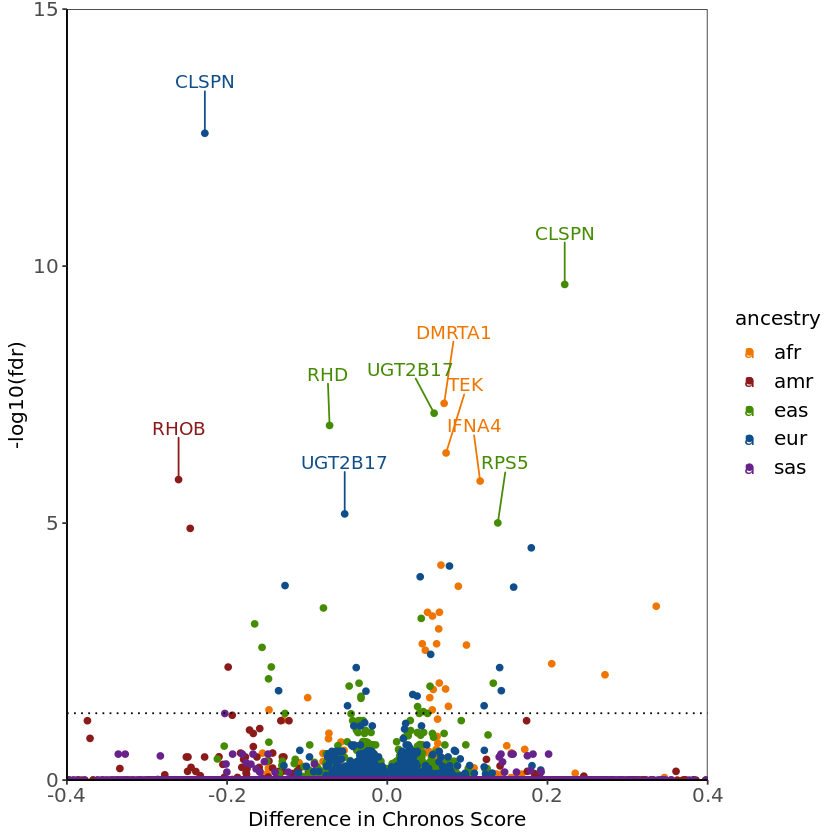

In [7]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Now finally plot the volcano plot
merged.df.for.volcano.plot %>%
ggplot(aes(x = differential, y = -log10(fdr), color = ancestry)) +
geom_point(aes(x = differential, y = -log10(fdr), color = ancestry)) +
geom_hline(linetype = "dotted", yintercept = 1.301) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("-log10(fdr)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0), limits = c(0, 15)) +
scale_x_continuous(expand = c(0,0), limits = c(-0.4, 0.4)) +

geom_text_repel(
aes(label=ifelse(-log10(fdr) > 5, 
as.character(gene),'')), 
box.padding = 0.5,
nudge_y = 1,
segment.ncp = 3,
segment.angle = 20)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
ggsave("r4c2_volcano_plot.pdf", width = 4, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4
gsutil cp r4c2_volcano_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now let's compare the ancestry-associated dependencies in our original analysis vs those in the lineage-correted analysis.


This analysis is now updated to only include the lineage-corrected ancestry-associated genes.

In [1]:
#Load in the original p-values
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
original.ancestry.association.pvals = read.table("ancestry_locus_gene_associations.txt", sep = "\t", header = T)

In [ ]:
#Get a vector of ancestry-associated genes
#Make a vector of all of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [10]:
#Create a merged dataset with only the ancestry-associated genes
df.for.ancestry.associated.scatterplot = original.ancestry.association.pvals %>%
mutate(ancestry = tolower(ancestry)) %>%
mutate("flag" = paste(gene, ancestry, sep = "_")) %>%
rename("old_pval" = pval, "old_difference" = difference, "old_fdr" = FDR) %>%
inner_join(merged.df.for.volcano.plot, by = "flag") %>%
select(-ancestry.y, -gene.y) %>%
rename("gene" = gene.x, "ancestry" = ancestry.x, "new_differential" = differential, "new_fdr" = fdr)
       
       
head(df.for.ancestry.associated.scatterplot)

,gene,old_pval,old_difference,ancestry,old_fdr,flag,new_differential,new_fdr
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,A1BG,0.07814048,0.018967685,afr,0.9259430,A1BG_afr,0.018967685,0.998556
2,A1CF,0.08035465,-0.035117475,afr,0.9270243,A1CF_afr,-0.035117475,0.998556
3,A2M,0.58861022,-0.010031350,afr,1.0000000,A2M_afr,-0.010031350,0.998556
4,A2ML1,0.82034442,0.009988105,afr,1.0000000,A2ML1_afr,0.009988105,0.998556
5,A3GALT2,0.96604057,0.003320528,afr,1.0000000,A3GALT2_afr,0.003320528,0.998556
6,A4GALT,0.87594000,0.004528391,afr,1.0000000,A4GALT_afr,0.004528391,0.998556


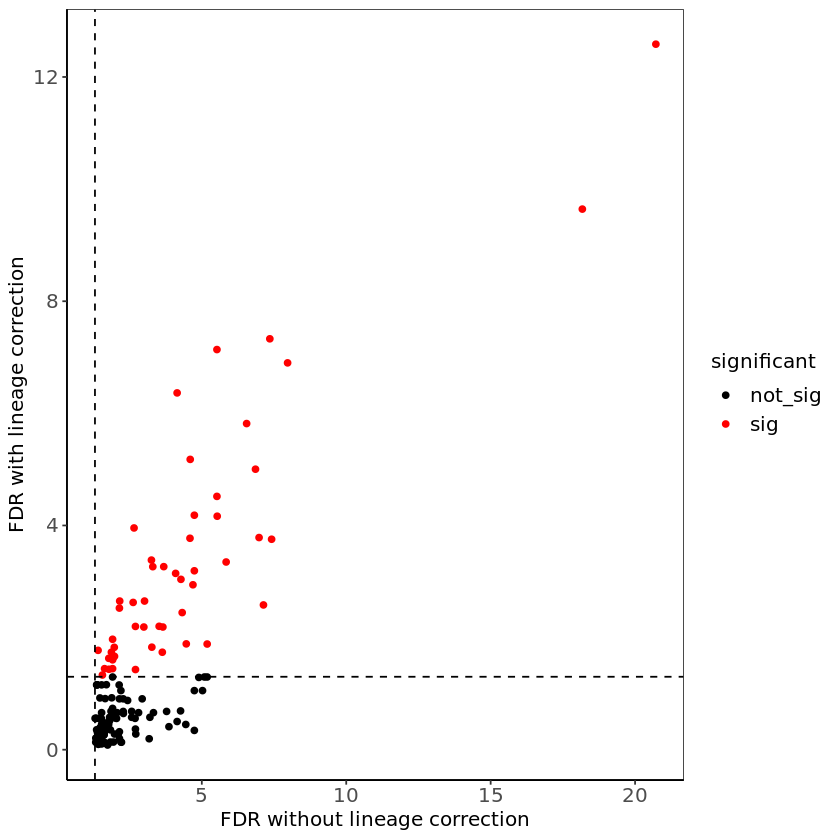

In [11]:
#Plot the scatterplot
df.for.ancestry.associated.scatterplot %>%
filter(old_fdr < 0.05) %>%
mutate("significant" = ifelse(old_fdr < 0.05 & new_fdr < 0.05, "sig", "not_sig")) %>%
ggplot(aes(x = -log10(old_fdr), y = -log10(new_fdr), color = significant)) +
geom_point() +

scale_color_manual(values = c("black", "red")) + 

geom_hline(yintercept = 1.301, linetype = 2) +
geom_vline(xintercept = 1.301, linetype = 2) +

theme_bw() +


theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("FDR with lineage correction") +
xlab("FDR without lineage correction")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4')
ggsave("r4c2_scatterplot.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4
gsutil cp r4c2_scatterplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [41]:
old.sig.genes = df.for.ancestry.associated.scatterplot %>%
filter(old_fdr < 0.05) %>%
pull(gene) %>%
unique() 

new.sig.genes = df.for.ancestry.associated.scatterplot %>%
filter(new_fdr < 0.05) %>%
pull(gene) %>%
unique()

#Compute the intersection between the two datasets
intersect(old.sig.genes, new.sig.genes) %>% length()

#Compute the ones that are only in new 
setdiff(new.sig.genes, old.sig.genes) %>% length()

#Compute the ones that are only in old
setdiff(old.sig.genes, new.sig.genes) %>% length()


[1] 40

[1] 9

[1] 58